In [1]:
### import matplotlib.pyplot as plt
from matplotlib import animation, rc, pyplot as plt
import pickle
import os
import shutil 
from scipy import interpolate, signal, linalg, spatial
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, accuracy_score
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering, KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from numba import cuda, jit, njit, prange, vectorize
import networkx as nx
import grakel
import netlsd
from collections import defaultdict, Counter
from itertools import combinations, product
import pandas as pd
import numpy as np
import math
import cv2
import copy
from multiprocessing import cpu_count
from joblib import Parallel, delayed, pool
from IPython.display import clear_output, HTML
from IPython.core.debugger import set_trace
import torch
from tqdm import tqdm_notebook
N_CPU = cpu_count()
TOY_DATASET = False


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module

In [2]:
track = 'Circle'
mouse = 22
day = 1
calcium_df = pd.read_csv(f"./data/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
spikes_df = pd.read_csv(f"./data/{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv", index_col=0)
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)


trim=100
cadata = calcium_df.iloc[:,7:][trim:-trim].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim:-trim].T.values # [n_neurons, T]
rears_events = rears_events[trim:-trim]
time = calcium_df['time_s'][trim:-trim].values

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values
rears_indicators = np.pad(rears_indicators, 1)

cells_with_spikes = np.sum(spdata, axis = 1) > 1.

spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]

N, T = spdata.shape

# scaler = MinMaxScaler()
# spdata = scaler.fit_transform(spdata)
# cadata = scaler.fit_transform(cadata)

coords = calcium_df[['x','y']][trim:-trim].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
# coords_ = coords / np.linalg.norm(coords, axis=-1)[:,None]

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# # speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign

# acceleration
acceleration = np.diff(speed, prepend=speed[0])

acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi
}

In [3]:
green = calcium_df[['x_green', 'y_green']].values
red = calcium_df[['x_red', 'y_red']].values

head_direction = green - red
head_direction -= head_direction.mean(0)[None,:]
head_direction_ = head_direction / np.linalg.norm(head_direction, axis=-1)[:,None]

In [4]:
head_direction_

array([[0.62457476, 0.78096502],
       [0.65810827, 0.75292331],
       [0.6778633 , 0.73518796],
       ...,
       [0.85077857, 0.52552433],
       [0.83346679, 0.55256956],
       [0.81105374, 0.58497164]])

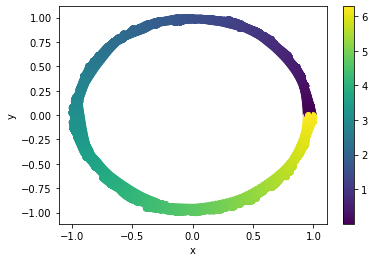

In [5]:
plt.scatter(coords_[:,0], coords_[:,1], c=phi)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [6]:
dt = 100 
# make torch kernel
T_RISE = 5 # 15 for orig, 5 for toy
T_OFF = 5 # 40 for orig, 5 for toy

kernel_type = 'gaussian' # 'exponential'

kernel_size = 49 #int(dt//(mu)) # 400 for orig, 50 for toy

if kernel_type == 'gaussian':
    assert kernel_size%2==1
    sygma = kernel_size//7
    sp = signal.gaussian(M=kernel_size, std=sygma)

elif kernel_type == 'exponential':
    def spike_form(t):
        return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)
    x = np.linspace(0, kernel_size, num = kernel_size)
    sp = spike_form(x)[::-1].copy()

sp_torch = torch.tensor(sp).float().cuda()
sp_torch_batch = sp_torch.unsqueeze(0).unsqueeze(0)
spdata_torch = torch.tensor(spdata).float().cuda()

In [7]:
def calc_spike_similarity_cuda(sp_torch_batch, spdata_torch, save=True, corr_dir=None, i=None):
    dt = spdata_torch.shape[-1]
    kernel_size = sp_torch_batch.shape[-1]
    n = sp_torch.shape[0]
    result_torch = torch.conv1d(input=spdata_torch.unsqueeze(1), weight=sp_torch_batch, padding=kernel_size//2).squeeze(1)
    norms = torch.norm(result_torch, p=2, dim=1).unsqueeze(1)
    sim_map = result_torch@result_torch.transpose(0,1) / (norms@norms.transpose(0,1) + 1e-10)
    sm = sim_map.detach().cpu().numpy()
    # delete diagonal
    diag = np.diag(np.diagonal(sm))
    sm = sm - diag
    sm[sm > 1] = 1
    # save
    if save:
        path = os.path.join(corr_dir, str(i))
        np.save(path, sm)
        return path
    else:
        return sm

In [8]:
start = 0
end=T-dt 

name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}'

if kernel_type == 'exponential':
    corr_dir = f'./corrmap_data/corrmaps_' + name +  f'_dt{dt}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'
    
elif kernel_type == 'gaussian':
    corr_dir = f'./corrmap_data/corrmaps_' + name + f'_dt{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{sygma}' 

REMAKE = False
if REMAKE:
    if os.path.exists(corr_dir):
        shutil.rmtree(corr_dir)
    os.makedirs(corr_dir, exist_ok=True)
    
corr_paths = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])

In [9]:
n_descr_start=1000 #1000
n_descr = end-n_descr_start # 20*dt

In [10]:
len(corr_paths)

18475

# Clustering

In [17]:
def compute_norm_laplacian_eig(A):
    
    # normalized Laplacian
    d = A.sum(0)
    D = np.diag(d)
    L = D - A
    
    if True:# normalized
        D_sqrt_diag = np.sqrt(d)
        D_sqrt_diag[D_sqrt_diag>0] = 1./D_sqrt_diag[D_sqrt_diag>0]
        D_sqrt_diag = np.diag(D_sqrt_diag)
        L = D_sqrt_diag@(L@D_sqrt_diag)
    w,v = np.linalg.eig(L.astype(np.complex64))
    
    return w.real,v.real

def get_n_clusters(p, cum_thresh, strong_thresh):
    A = np.load(p)
    non_single_nodes_mask = A.sum(0) > 0 
    connection_mask = (A >= strong_thresh).any(axis=0) + (A.sum(0) >= cum_thresh)
    non_single_nodes = connection_mask*non_single_nodes_mask
    A = A[non_single_nodes][:,non_single_nodes]
    return sum(compute_norm_laplacian_eig(A)[0] < 1.), non_single_nodes.sum()

def get_cum_connections(p):
    A = np.load(p)
    non_single_nodes = A.sum(0) > 0
    A = A[non_single_nodes][:,non_single_nodes]
    return A.mean()

def compute_clustering(path):
    A = np.load(path)
    non_single_nodes = A.sum(0) > 0
    A = A[non_single_nodes][:,non_single_nodes]
    
    d = compute_norm_laplacian_eig(A)
    n_clusters = max(sum(d[0] < 1e-1), 5)
    
    labels = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42).fit_predict(A)

    return (labels, non_single_nodes)

def mean_entropy(y):
    pdf = np.histogram(y, bins=len(np.unique(y)), density=True)[0]
    H = -np.sum(pdf*np.log(pdf))
    return H

In [18]:
# connection_threshol_results = defaultdict(dict)

# np.random.seed(42)
# corr_paths_subset = np.random.choice(corr_paths, size=1000, replace=False)

# cumulative_connection_threshold_range = [0, 2] #[0, 2.5, 5., 10]
# strong_connection_threshold_range = [0, 0.9] #[0, 0.7, 0.8, 0.9]

# fig, axes = plt.subplots(ncols=len(cumulative_connection_threshold_range),
#                          nrows=len(strong_connection_threshold_range), figsize=(20,20))

# for i,strong_thresh in enumerate(strong_connection_threshold_range):
#     for j,cum_thresh in enumerate(cumulative_connection_threshold_range):
        
#         n_clusters = Parallel(n_jobs=20)(delayed(get_n_clusters)(p, cum_thresh, strong_thresh) for p in corr_paths_subset)
        
#         n_nodes = [r[1] for r in n_clusters]
#         n_clusters = [r[0] for r in n_clusters]

#         connection_threshol_results[thr]['n_nodes'] = n_nodes
#         connection_threshol_results[thr]['n_clusters'] = n_clusters

#         axes[i,j].hist(n_nodes, bins=50)
#         axes[i,j].set_title(f'strong_thresh: {strong_thresh} \n cum_thresh: {cum_thresh} \n n_clusters: {len(np.unique(n_clusters))}')

# plt.tight_layout()
# plt.show()

In [19]:
# fig, axes = plt.subplots(ncols=len(cumulative_connection_threshold_range),
#                          nrows=len(strong_connection_threshold_range), figsize=(20,20))
# for i,strong_thresh in enumerate(strong_connection_threshold_range):
#     for j,cum_thresh in enumerate(cumulative_connection_threshold_range):
        
#         n_clusters = Parallel(n_jobs=20)(delayed(get_n_clusters)(p, cum_thresh, strong_thresh) for p in tqdm_notebook(corr_paths_subset))
        
#         n_nodes = [r[1] for r in n_clusters]
#         n_clusters = [r[0] for r in n_clusters]

#         connection_threshol_results[thr]['n_nodes'] = n_nodes
#         connection_threshol_results[thr]['n_clusters'] = n_clusters

#         axes[i,j].hist(n_nodes, bins=50)
#         axes[i,j].set_title(f'strong_thresh: {strong_thresh} \n cum_thresh: {cum_thresh} \n n_clusters: {len(np.unique(n_clusters))}')

# plt.tight_layout()
# plt.show()

In [20]:
# cum_connections = Parallel(n_jobs=-1)(delayed(get_cum_connections)(p) for p in tqdm_notebook(np.random.choice(corr_paths, size=5000, replace=False)))
# plt.hist(cum_connections, bins=50)
# plt.show()

In [21]:
# # PLOT
# for c in choice:
#     fig, axes = plt.subplots(ncols=len(metrics), nrows=1, figsize=(20,5))
#     for i,metric_name in enumerate(metrics.keys()):
#         for thr in thr_range:
#             y = metrics[metric_name][c][thr]
#             axes[i].plot(clustering_range,y, label=f'thr={thr}')
#         axes[i].set_title(f'window number {c}')
#         axes[i].set_xlabel('number of clusters')
#         axes[i].set_ylabel(metric_name)
#         axes[i].legend()
# plt.show()

In [22]:
clustering_results = Parallel(n_jobs=10)(delayed(compute_clustering)(p) for p in tqdm_notebook(corr_paths))

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


# Find common subgroups

In [23]:
C = -np.ones((N, len(corr_paths)))
for i, c in enumerate(clustering_results):
    labels, non_single_nodes = c
    C[non_single_nodes, i] = labels

def clustering_v_measure_score(x1,x2):
    non_noise = (x1!=-1)*(x2!=-1)
    non_noise_total = non_noise.sum()
    if non_noise_total < 5:
        return 0
    else:
        return v_measure_score(x1[non_noise], x2[non_noise])
    
def clustering_accuracy_score(x1,x2):
    '''
    x1 - [T clusters]
    x2 - [T clusters]
    '''
    non_noise = (x1!=-1)*(x2!=-1)
    non_noise_total = non_noise.sum()
    if non_noise_total < n_descr//10:
        return 0
    else:
        acc = accuracy_score(x1[non_noise], x2[non_noise])
#         weight = #(non_noise_total/len(x1))
        return acc if non_noise_total > 200 else 0 

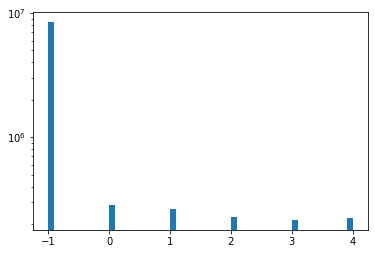

In [24]:
plt.hist(C.flatten(), bins=50)
plt.yscale('log')
plt.show()

In [25]:
clustering_similarity = spatial.distance.squareform(spatial.distance.pdist(C, 
                                                    metric=clustering_accuracy_score))

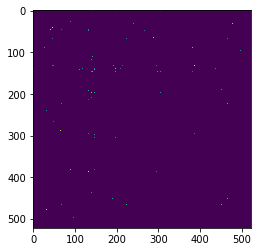

In [27]:
plt.imshow(clustering_similarity)

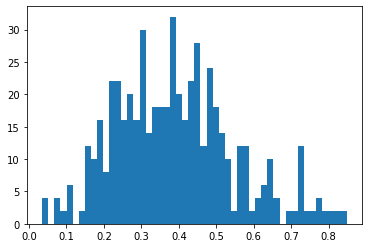

In [28]:
plt.hist(clustering_similarity[clustering_similarity > 0].flatten(), bins=50)
plt.show()

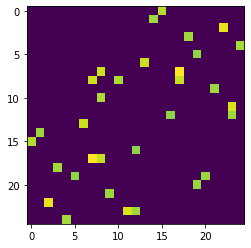

In [29]:
clustering_similarity_thr = clustering_similarity.copy()
clustering_similarity_thr[clustering_similarity_thr < 0.7] = 0
# clustering_similarity_thr[clustering_similarity_thr >= 0.5] = 1

clustering_similarity_non_single_thr = clustering_similarity_thr.copy()
cs_non_single_thr = np.arange(N)[clustering_similarity_non_single_thr.sum(0) > 0]

clustering_similarity_non_single_thr = clustering_similarity_non_single_thr[cs_non_single_thr][:,cs_non_single_thr]
plt.imshow(clustering_similarity_non_single_thr)
plt.show()

In [30]:
x1 = C[41]
x2 = C[46]
non_noise = (x1!=-1)*(x2!=-1)
non_noise_total = non_noise.sum()
accuracy_score(x1[non_noise], x2[non_noise])#*(non_noise_total/len(x1))

0.785025706940874

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


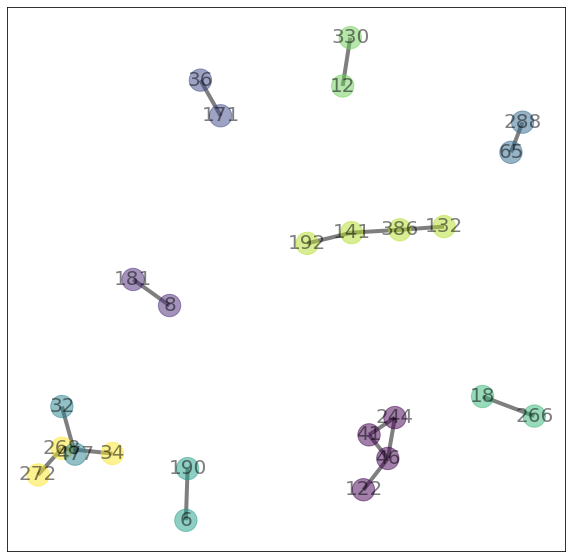

In [56]:
cs_non_single_thr_map = dict(zip(np.arange(len(cs_non_single_thr)), cs_non_single_thr))

G = nx.Graph()
G.add_nodes_from(cs_non_single_thr)
cs_non_single_thr_edges = []
for i1,i2 in zip(*np.where(clustering_similarity_non_single_thr > 0)):
    i1=cs_non_single_thr_map[i1]
    i2=cs_non_single_thr_map[i2]
    assert (i1 in cs_non_single_thr) and (i2 in cs_non_single_thr)
    G.add_edge(i1,i2)
    
G = G.to_undirected()
similar_neurons_labels = SpectralClustering(n_clusters=10, 
                                            affinity='precomputed').fit_predict(clustering_similarity_non_single_thr)
    
plt.figure(figsize=(10,10))
nx.draw_networkx(G, node_size=500, pos=nx.spring_layout(G, k=0.15, iterations=20), node_color=similar_neurons_labels, width=4, alpha=0.5, font_size=20) # , node_color=similar_neurons_labels
plt.show()

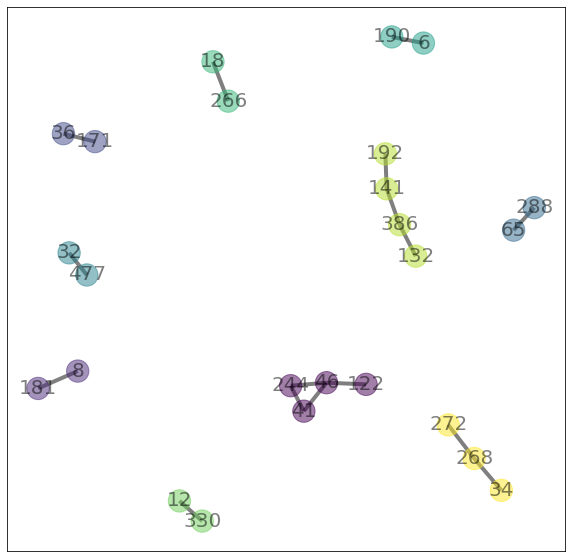

In [57]:
plt.figure(figsize=(10,10))
nx.draw_networkx(G, node_size=500, pos=nx.spring_layout(G, k=0.15, iterations=20), node_color=similar_neurons_labels, width=4, alpha=0.5, font_size=20) # , node_color=similar_neurons_labels
plt.show()

In [60]:
clusterng_neural_groups = [list(comp) for comp in list(nx.connected_components(G))]

In [64]:
# high_corr_nodes_all = np.unique(np.concatenate([index_to_nodes[w_ind1[k], w_ind2[k]] for k in vis_i]))

# sub_groups = []

# for k in np.unique(similar_neurons_labels):
#     if k != -1:
#         cs_k_clust_ind = cs_non_single_thr[similar_neurons_labels == k]
#         print ('subgroup with similar clusterings', cs_k_clust_ind)
#         sub_groups_intersection = np.intersect1d(high_corr_nodes_all, cs_k_clust_ind, assume_unique=True)
#         print('Intersection: \n', sub_groups_intersection)
#         if len(sub_groups_intersection) > 2:
#             sub_groups.append(intersection)
#         print('--------------------------')

# Visualize these subsets

сильно скореллированная группа нейронов скорее всего образует клику в графе!

# Find cliques

In [66]:
def find_cliques(A, thr=0.9):
    A_n = A.copy()
    A_n[A_n < thr] = 0
    N = A_n.shape[0]
    non_single_nodes = np.arange(N)[A_n.sum(0) > 0]
    A_n = A_n[non_single_nodes][:,non_single_nodes]
    G = nx.from_numpy_array(A_n)
    cliques = list(nx.find_cliques(G))
    cliques = [non_single_nodes[cl] for cl in cliques if len(cl) > 5]
    return cliques

In [67]:
A_s = Parallel(n_jobs=20)(delayed(np.load)(p) for p in tqdm_notebook(corr_paths[n_descr_start:n_descr_start+n_descr]))
A_s = np.stack(A_s, 0)

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [68]:
A_s.shape, n_descr, len(corr_paths[n_descr_start:n_descr_start+n_descr])

((17475, 522, 522), 17475, 17475)

In [69]:
len(corr_paths), n_descr, T

(18475, 17475, 18575)

In [70]:
cliques_results = Parallel(n_jobs=-1)(delayed(find_cliques)(A_s[i], thr=0.9) for i in tqdm_notebook(range(n_descr))) # np.random.choice(np.arange(n_descr), size=3000, replace=False)

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


# Graph by cliques occurancies

In [71]:
S_cliq = np.zeros((N,N))
for cliq_list in tqdm_notebook(cliques_results):
    for cliq in cliq_list:
        if len(cliq) > 0:
            S_cliq[np.meshgrid(cliq, cliq)] += 1
            
S_cliq[np.diag_indices_from(S_cliq)] = 0
S_cliq = S_cliq/S_cliq.max()

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


In [77]:
thr_cliq = 0.7
S_cliq_thr = S_cliq.copy()
S_cliq_thr[S_cliq_thr < thr_cliq] = 0
cliq_non_single_thr = np.arange(N)[S_cliq_thr.sum(0) > 0]

In [78]:
G_cliques = nx.Graph()
G_cliques.add_nodes_from(cliq_non_single_thr)
for i1,i2 in zip(*np.where(S_cliq_thr > 0)):
    G_cliques.add_edge(i1,i2, weight=S_cliq_thr[i1,i2])

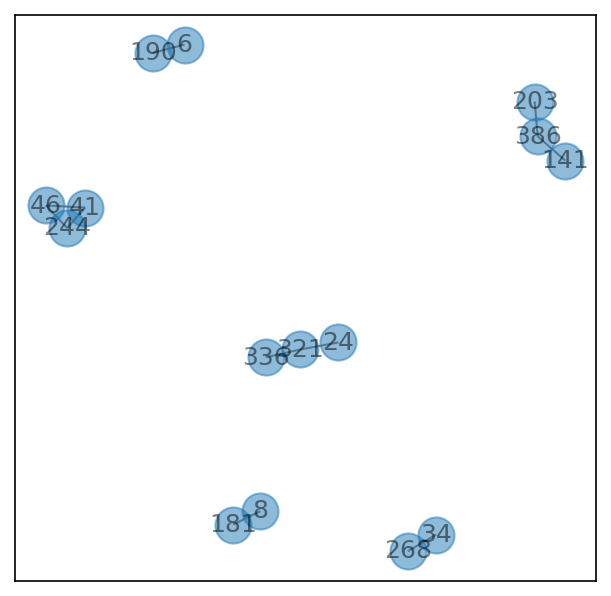

In [79]:
plt.figure(figsize=(5,5), dpi=150)
nx.draw_networkx(G_cliques, alpha=0.5)
plt.show()

similar to previos from-clustering graph!

In [80]:
neural_groups = list(nx.algorithms.components.connected_components(G_cliques))

In [89]:
len(neural_groups), len(clusterng_neural_groups)

(6, 10)

In [86]:
neural_groups_similarity = np.zeros((len(neural_groups), len(clusterng_neural_groups)))

for i,neural_group in enumerate(neural_groups):
    for j,c_neural_group in enumerate(clusterng_neural_groups):
        ng_inter = len(np.intersect1d(list(neural_group), c_neural_group)) /  min(len(neural_group), len(c_neural_group))
        neural_groups_similarity[i,j] = ng_inter
#         neural_groups_similarity[j,i] = ng_inter     

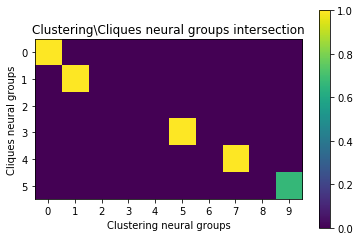

In [91]:
plt.imshow(neural_groups_similarity)
plt.colorbar()
plt.title('Clustering\Cliques neural groups intersection')
plt.xlabel('Clustering neural groups')
plt.ylabel('Cliques neural groups')
plt.xticks(ticks=range(len(neural_group)), labels=range(len(neural_group)))
plt.xticks(ticks=range(len(clusterng_neural_groups)), labels=range(len(clusterng_neural_groups)))
plt.show()

No handles with labels found to put in legend.


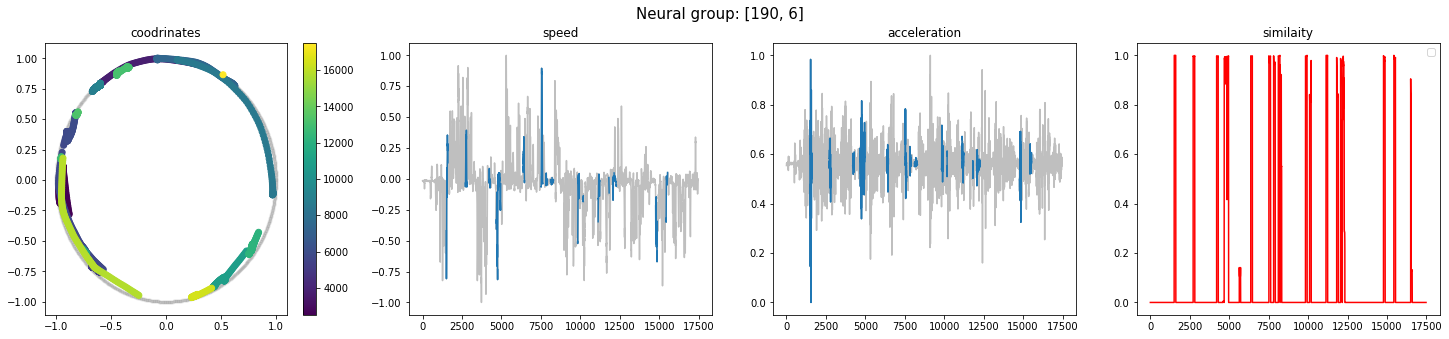

No handles with labels found to put in legend.


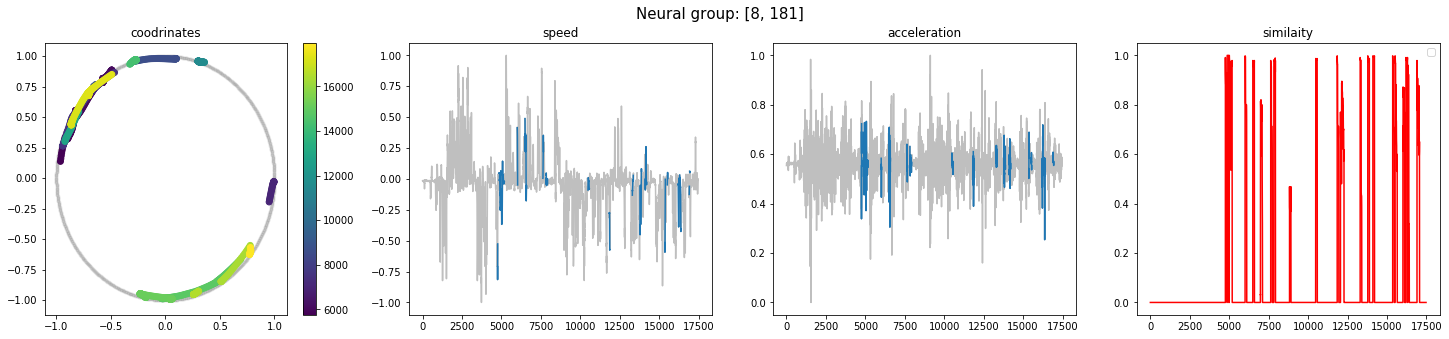

No handles with labels found to put in legend.


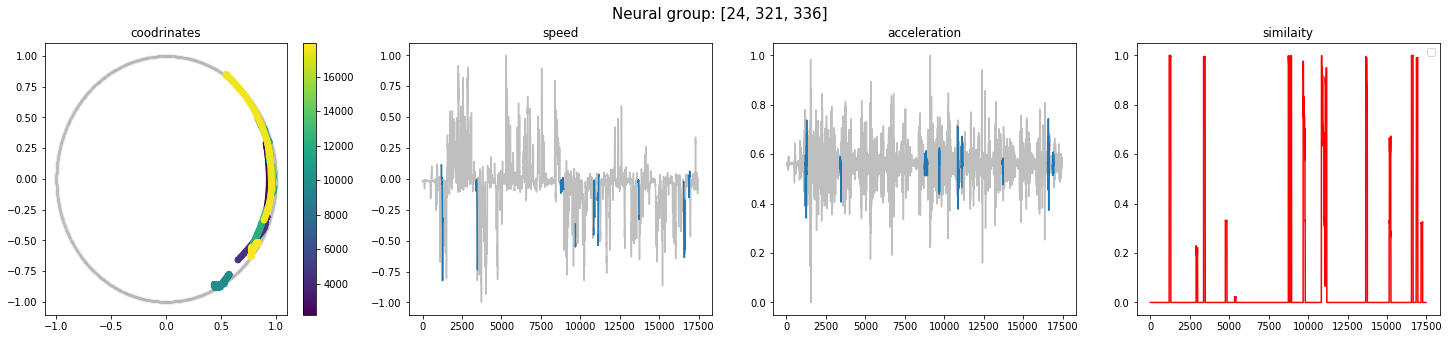

No handles with labels found to put in legend.


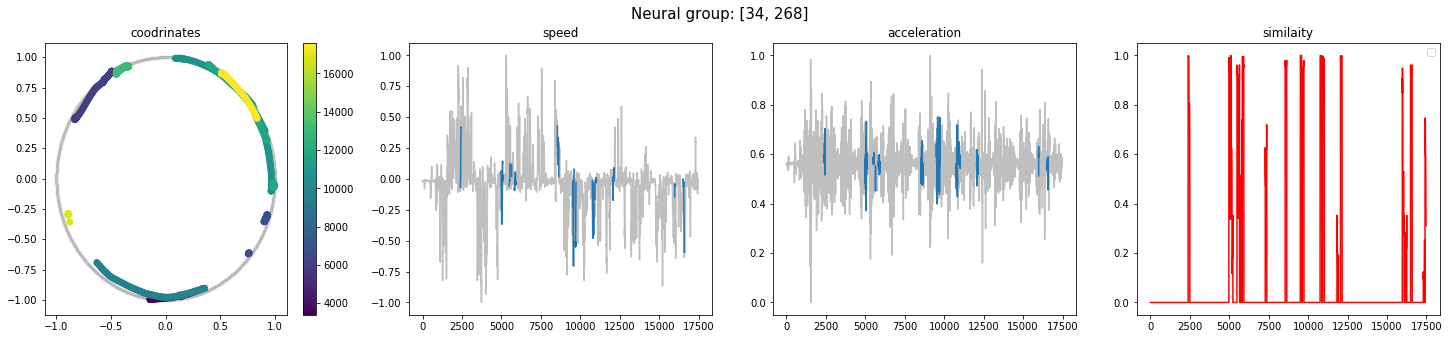

No handles with labels found to put in legend.


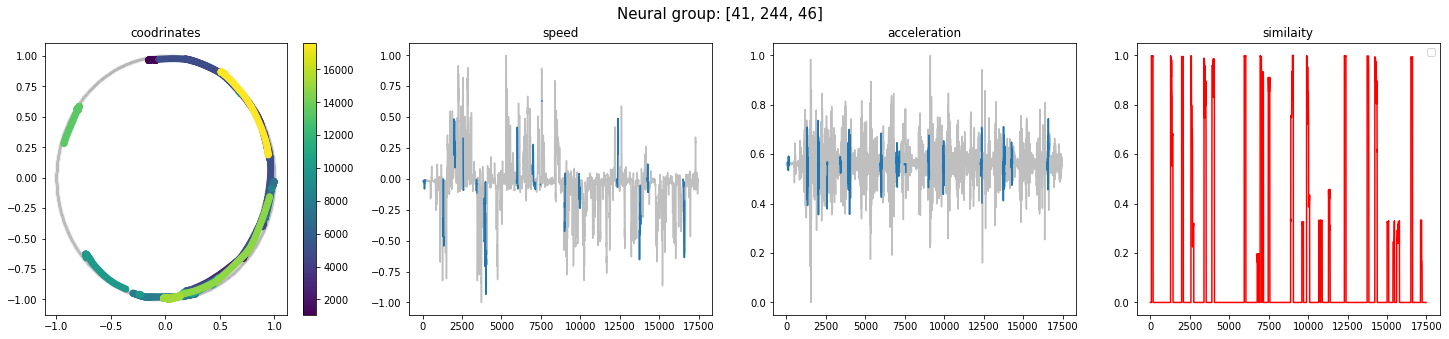

No handles with labels found to put in legend.


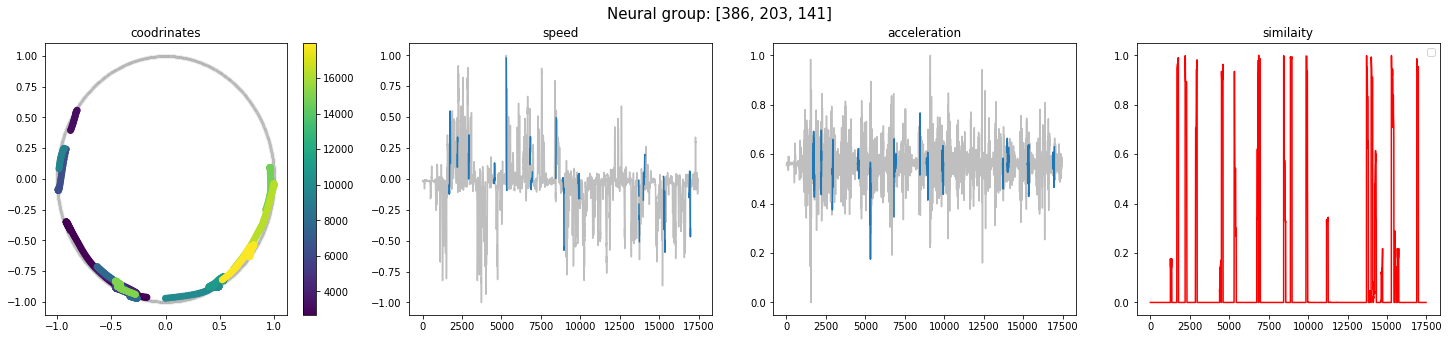

In [201]:
for neural_group in neural_groups:
    neural_group = list(neural_group)

    # window correlation
    sim_m_mean = np.array([sim_m[neural_group][:,neural_group][np.triu_indices_from(sim_m[neural_group][:,neural_group], k=1)].mean() for sim_m in A_s])
    coords_subset = coords_[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]

    speed_subset = speed_.copy()[n_descr_start:n_descr_start+n_descr]
    speed_subset_masked = speed_subset.copy()
    speed_subset_masked[sim_m_mean <= 0.9] = np.nan

    acc_subset = acceleration_.copy()[n_descr_start:n_descr_start+n_descr]
    acc_subset_masked = acc_subset.copy()
    acc_subset_masked[sim_m_mean <= 0.9] = np.nan
    
    # index_subset = np.arange(T)[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]
    colorscale = np.arange(len(coords_))[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]
    
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
    angle_range = np.linspace(0, 2*np.pi, 1000)
    axes[0].scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
    scat = axes[0].scatter(coords_subset[:,0], coords_subset[:,1], label='neural group correlation', c=colorscale)
    fig.colorbar(scat, ax=axes[0])
    axes[0].set_title('coodrinates')

    axes[1].plot(speed_subset,color='grey',alpha=0.5)
    axes[1].plot(speed_subset_masked, label='neural group correlation')
    axes[1].set_title('speed')

    axes[2].plot(acc_subset,color='grey',alpha=0.5)
    axes[2].plot(acc_subset_masked, label='neural group correlation')
    axes[2].set_title('acceleration')
    
    axes[3].plot(sim_m_mean, color='red')
    axes[3].set_title('similaity')

    fig.suptitle(f'Neural group: {neural_group}', fontsize=15)
    plt.legend()
    plt.show()


# Clusteiring cliques

is there a better embedding than one-hot encoding?

No handles with labels found to put in legend.


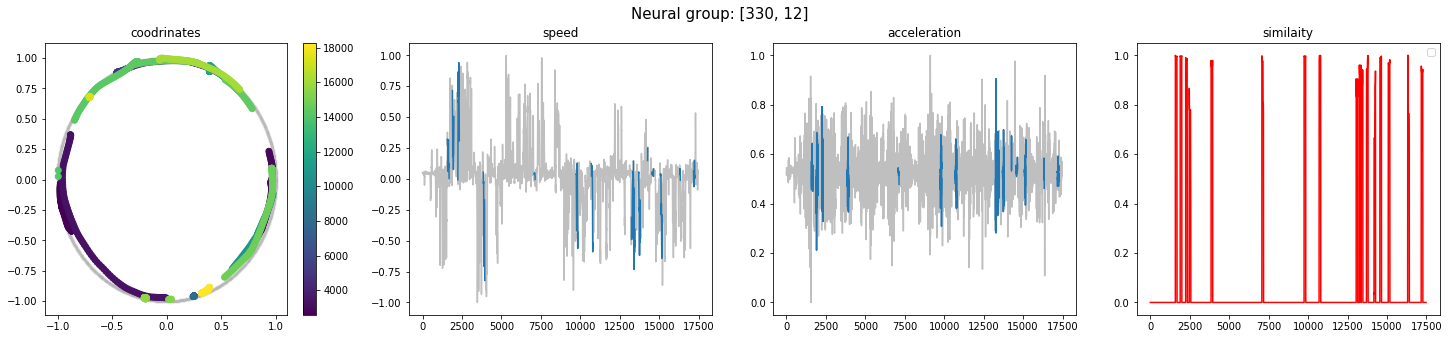

No handles with labels found to put in legend.


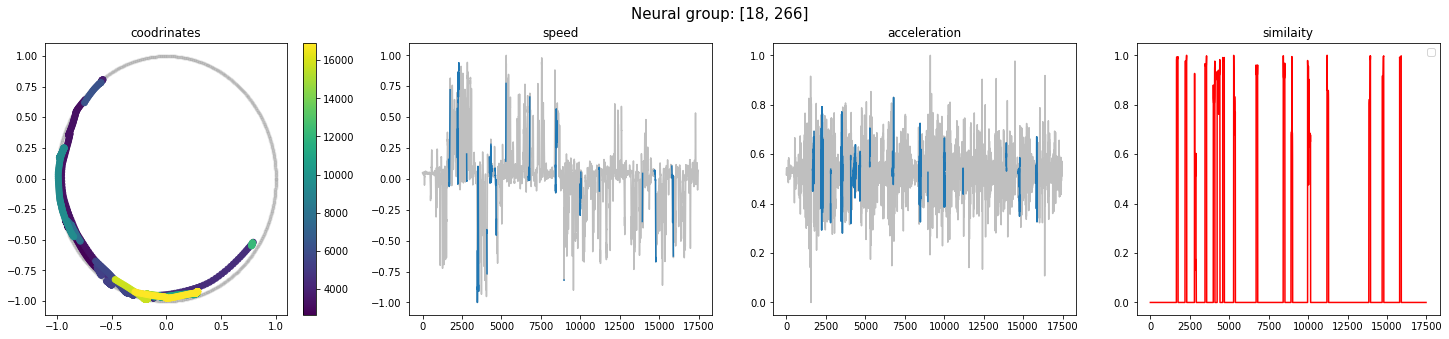

No handles with labels found to put in legend.


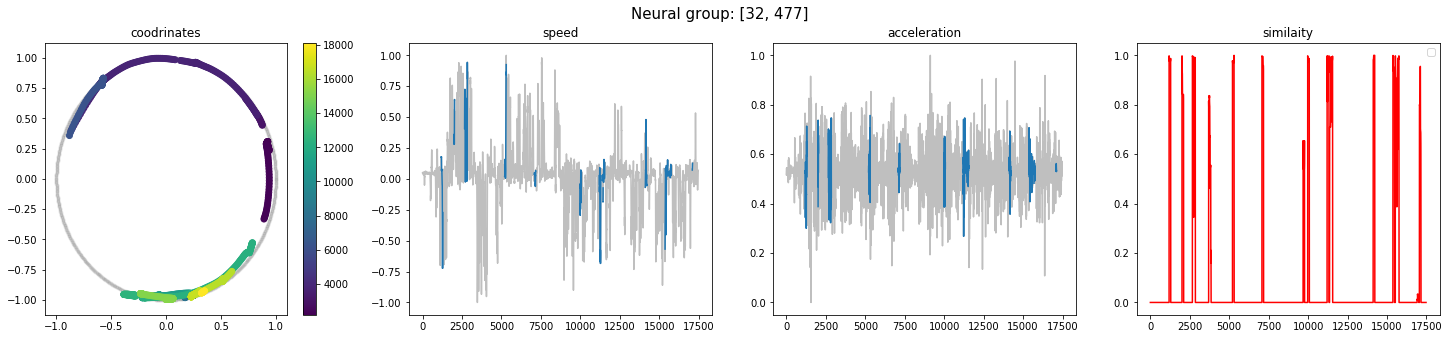

No handles with labels found to put in legend.


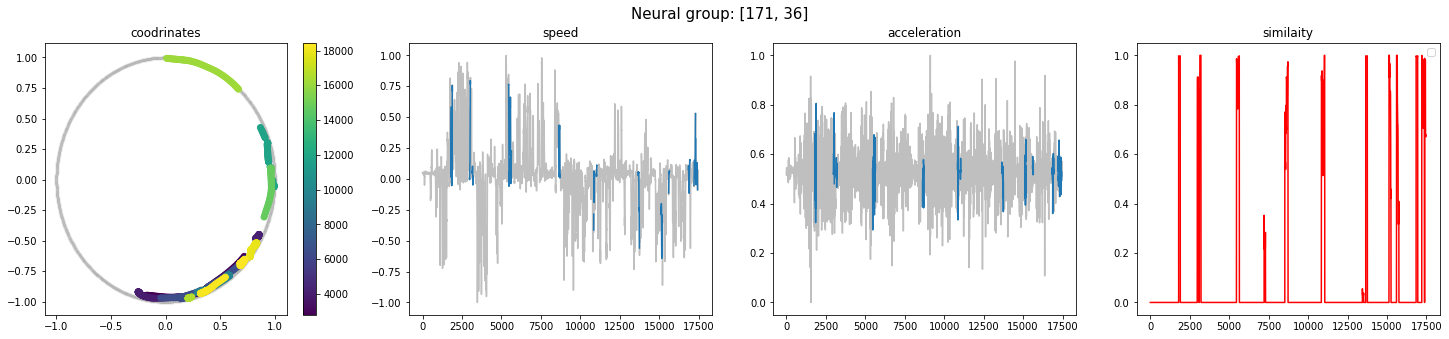

No handles with labels found to put in legend.


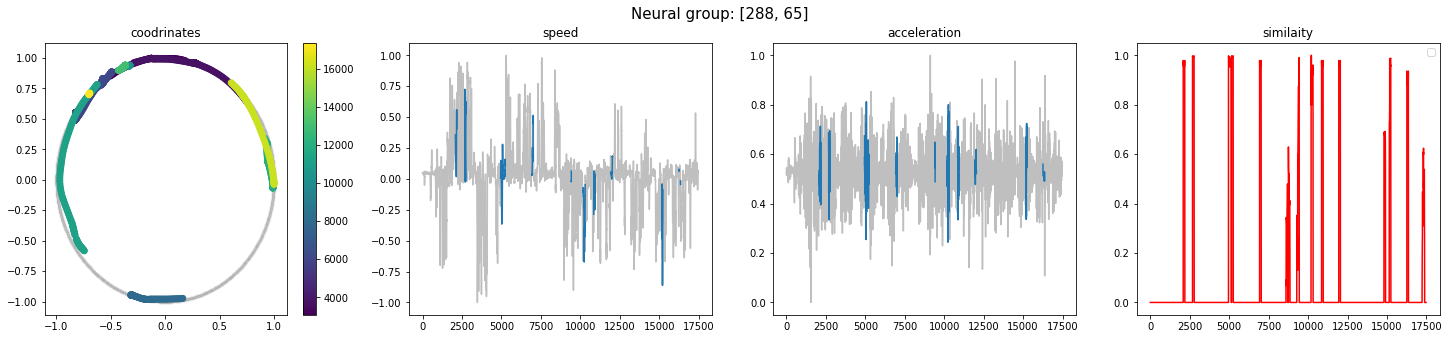

In [99]:
for neural_group in [cl for i,cl in enumerate(clusterng_neural_groups) if neural_groups_similarity[:,i].sum() == 0]:
    neural_group = list(neural_group)

    # window correlation
    sim_m_mean = np.array([sim_m[neural_group][:,neural_group][np.triu_indices_from(sim_m[neural_group][:,neural_group], k=1)].mean() for sim_m in A_s])
    coords_subset = coords_[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]

    speed_subset = speed_.copy()[n_descr_start:n_descr_start+n_descr]
    speed_subset_masked = speed_subset.copy()
    speed_subset_masked[sim_m_mean <= 0.9] = np.nan

    acc_subset = acceleration_.copy()[n_descr_start:n_descr_start+n_descr]
    acc_subset_masked = acc_subset.copy()
    acc_subset_masked[sim_m_mean <= 0.9] = np.nan
    
    # index_subset = np.arange(T)[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]
    colorscale = np.arange(len(coords_))[n_descr_start:n_descr_start+n_descr][sim_m_mean > 0.9]
    
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
    angle_range = np.linspace(0, 2*np.pi, 1000)
    axes[0].scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
    scat = axes[0].scatter(coords_subset[:,0], coords_subset[:,1], label='neural group correlation', c=colorscale)
    fig.colorbar(scat, ax=axes[0])
    axes[0].set_title('coodrinates')

    axes[1].plot(speed_subset,color='grey',alpha=0.5)
    axes[1].plot(speed_subset_masked, label='neural group correlation')
    axes[1].set_title('speed')

    axes[2].plot(acc_subset,color='grey',alpha=0.5)
    axes[2].plot(acc_subset_masked, label='neural group correlation')
    axes[2].set_title('acceleration')
    
    axes[3].plot(sim_m_mean, color='red')
    axes[3].set_title('similaity')

    fig.suptitle(f'Neural group: {neural_group}', fontsize=15)
    plt.legend()
    plt.show()


In [1449]:
def to_oh(cl):
    c_oh = np.zeros(N)
    for c in cl:
        c_oh[c] += 1
    return c_oh/len(cl)

def cliques_lists_intersection(cl1, cl2):
    intersections = []
    for c1 in cl1:
        for c2 in cl2:
            intr = len(np.intersect1d(c1,c2)) / max(len(c1), len(c2))
            intersections.append(intr)
    return max(intersections)

# def to_oh(cl):
#     oh_s = []
#     for c in cl:
#         c_oh = np.zeros(N)
#         c_oh[c] += 1
#         oh_s.append(c_oh)
#     return oh_s

# cliques_oh = np.concatenate([[c for c in to_oh(cl)] for cl in cliques_results if len(cl)>0])

# cliques_oh = [[i, to_oh(cl)] for i,cl in enumerate(cliques_results) if len(cl)>0]
# cliques_numbers = np.array([c[0] for c in cliques_oh])
# cliques_oh = np.stack([c[1] for c in cliques_oh])
# cliques_oh_std = RobustScaler().fit_transform(cliques_oh)

# pca = PCA(random_state=42)
# pca.fit_transform(cliques_oh_std)
# explained_variance = pca.explained_variance_/pca.explained_variance_.sum()
# n_pca_components = np.arange(N)[np.cumsum(explained_variance) > 0.95][0]
# cliques_oh_std_pca = cliques_oh_std@pca.components_[:n_pca_components].T 

In [1625]:
# param_grid = [15,20,25,30]
# S_cliques_dict = defaultdict(dict)
# good_cliques = defaultdict(dict)
# umap_results = defaultdict(dict)

# fig, axes = plt.subplots(nrows=1, ncols=len(param_grid), figsize=(10*len(param_grid), 20), dpi=200)
# for i,param in tqdm_notebook(enumerate(param_grid)):
    
#     ump = UMAP(metric='manhattan', init='random', n_neighbors=param, random_state=42, min_dist=0.1, n_jobs=-1, verbose=1) 
#     cliques_oh_ump = ump.fit_transform(cliques_oh_std_pca)
#     clear_output()
#     labels = DBSCAN(min_samples=20, eps=0.6).fit_predict(cliques_oh_ump) #OPTICS(n_jobs=-1, max_eps=0.5, min_samples=3).fit_predict(cliques_oh_ump)
#     labels_unique = np.unique(labels[labels != -1])
#     axes[0,i].scatter(cliques_oh_ump[:,0][labels==-1], cliques_oh_ump[:,1][labels==-1], alpha=0.3, color='grey')
#     axes[0,i].scatter(cliques_oh_ump[:,0][labels!=-1], cliques_oh_ump[:,1][labels!=-1], alpha=0.3, c=labels[labels!=-1])
#     axes[0,i].set_title(f'n_clusters: {len(labels_unique)}')
#     umap_results[param]['embeddnig'] = cliques_oh_ump
#     umap_results[param]['labels'] = labels
    
# plt.show()

In [1496]:
# labels_unique = np.unique(labels[labels != -1])

# def S_cliques_similarity(k):
# #     for k in tqdm_notebook(labels_unique):
#     cliques_numbers_k = cliques_numbers[labels == k]
#     cliques_results_k = [cliques_results[i] for i in cliques_numbers_k]
#     cliques_n_k = len(cliques_results_k)
#     S_cliques = np.zeros((cliques_n_k, cliques_n_k))
#     for i in range(cliques_n_k):
#         for j in range(i+1, cliques_n_k):
#             cli = cliques_lists_intersection(cliques_results_k[i], cliques_results_k[j])
#             S_cliques[i,j] = cli
#             S_cliques[j,i] = cli

# #     S_cliques_dict[param][k] = S_cliques
# #     mean_incluster_cliq_similarity.append(S_cliques.mean())
#     return S_cliques
# #         good cluster -> let's check average cliques
# #     if S_cliques.mean() > 0.8:
# #         good_cliques[param][k] = cliques_results_k

# mean_incluster_cliq_similarity = Parallel(n_jobs=-1)(delayed(S_cliques_similarity)(k) for k in tqdm_notebook(labels_unique))

In [ ]:
# def clique_similarity(cliq1, cliq2):
#     nodes1, cl1 = cliq1
#     nodes2, cl2 = cliq2
#     for c1 in cl1:
#         for c2 in cl2:
#             # re-enumerate to original nodes numbers
#             c1_ = nodes1[c1] 
#             c2_ = nodes2[c2]
#             sim = len(np.intersect1d(nodes1, nodes2))

In [ ]:
S = np.load('corrmap_data/S_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7.npy', allow_pickle=True)
index_to_nodes = np.load('corrmap_data/index_to_nodes_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7.npy', allow_pickle=True).item()

In [ ]:
convolve=True
interpolate=False

n = S.shape[0]
S_thresh = S.copy()
thr = 50
S_thresh[S_thresh < thr] = 0.
# S_thresh[S_thresh >= thr] = 1.

if convolve:
    S_torch = torch.tensor(S_thresh, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
    W_torch = torch.ones((1,1,99,99), dtype=torch.float32).cuda()
    S_hat = torch.conv2d(S_torch, weight=W_torch, padding=49).cpu().numpy()[0,0]
elif interpolate:
    S_torch = torch.tensor(S_shrinked, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
    S_interp = torch.nn.functional.interpolate(S_torch, size=(n_descr,n_descr)).cpu().numpy()[0,0]
    S_hat = S_interp
    S_hat[S_hat < .6] = 0.
    S_hat[S_hat >= .6] = 1.
    S_hat = cv2.medianBlur(S_hat.astype(np.uint8), ksize=71)
    S_hat = cv2.medianBlur(S_hat, ksize=71)
else:
    S_hat = S_thresh

imgname = f'corrmap_{n_descr_start}-{n_descr_start+n_descr}_dil{dilation}_thr{str(thr)[-1]}'
if convolve:
    imgname += '_convolve' 
    
if interpolate:
    imgname += '_interpolate' 
    
plt.figure(figsize=(10,10), dpi=300)
plt.plot(np.arange(n)+dt, np.arange(n),'r')
plt.plot(np.arange(n)-dt, np.arange(n),'r')
plt.title('')
plt.imshow(S_hat)
# plt.savefig('./img/' + imgname + '_' + '_'.join(corr_dir.split('/')[-1].split('_')[1:])  + '_eigformula')
plt.show() 

del S_hat